<a href="https://colab.research.google.com/github/Rohanpatel512/Obesity-Levels-Prediction/blob/master/obesity_level_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Exploration and Preprocessing

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, normalize, StandardScaler

In [4]:
# Load the obesity dataset and display first 10 rows
dataset = pd.read_csv('obesity_dataset.csv')
print(dataset.head(10))

    Age  Gender  Height  Weight        CALC FAVC  FCVC  NCP  SCC SMOKE  CH2O  \
0  21.0  Female    1.62    64.0          no   no   2.0  3.0   no    no   2.0   
1  21.0  Female    1.52    56.0   Sometimes   no   3.0  3.0  yes   yes   3.0   
2  23.0    Male    1.80    77.0  Frequently   no   2.0  3.0   no    no   2.0   
3  27.0    Male    1.80    87.0  Frequently   no   3.0  3.0   no    no   2.0   
4  22.0    Male    1.78    89.8   Sometimes   no   2.0  1.0   no    no   2.0   
5  29.0    Male    1.62    53.0   Sometimes  yes   2.0  3.0   no    no   2.0   
6  23.0  Female    1.50    55.0   Sometimes  yes   3.0  3.0   no    no   2.0   
7  22.0    Male    1.64    53.0   Sometimes   no   2.0  3.0   no    no   2.0   
8  24.0    Male    1.78    64.0  Frequently  yes   3.0  3.0   no    no   2.0   
9  22.0    Male    1.72    68.0          no  yes   2.0  3.0   no    no   2.0   

  family_history_with_overweight  FAF  TUE       CAEC                 MTRANS  \
0                            yes  0.0  

In [5]:
# Display the statistical summary of the dataset
print(dataset.describe())

               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000     1.000000     0.625350  
75% 

In [6]:
# Count the number of missing values
missing_values = dataset.isnull().sum()
# Report any missing values in the dataset
missing_values = np.array(missing_values[missing_values > 0])
if len(missing_values) == 0:
    print("No missing values in the dataset")
else:
    print("There are missing values in the dataset")

No missing values in the dataset


In [7]:
# Apply one-hot encoding to the categorical descriptive features
X = dataset[['Age', 'Gender', 'Height', 'Weight', 'CALC', 'FAVC', 'FCVC', 'NCP',
       'SCC', 'SMOKE', 'CH2O', 'family_history_with_overweight', 'FAF', 'TUE',
       'CAEC', 'MTRANS']]
Y = dataset['NObeyesdad']

encoder = OneHotEncoder(sparse_output=False)
enc = encoder.fit_transform(X[['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC']])
df = pd.DataFrame(enc)

X = X.drop(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC'], axis=1)
df.reset_index(drop=True, inplace=True)
X = pd.concat([X, df], axis=1)


Feature Engineering

In [8]:
#Creating derived features

X['BMI'] = X['Weight'] / (X['Height'] ** 2)

In [9]:
#Categorize BMI into weight categories as per https://www.nhlbi.nih.gov/
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

X['BMI_Category'] = X['BMI'].apply(categorize_bmi)


In [10]:
#Create Activity-to-Diet Ratio
X['Activity_to_Diet_Ratio'] = X['FAF'] / (X['FCVC'] + X['NCP'] + 1)

In [11]:
#Create a Healthy Lifestyle Score
X['Healthy_Lifestyle_Score'] = X['FAF'] + X['CH2O'] - X['TUE']


In [12]:
#Normalize continuous features
scaler = StandardScaler()
continuous_features = ['Age', 'Height', 'Weight', 'CH2O', 'FAF', 'TUE', 'BMI']
X[continuous_features] = scaler.fit_transform(X[continuous_features])


In [13]:
#One-hot encode BMI_Category
bmi_encoder = OneHotEncoder(sparse_output=False)
bmi_encoded = bmi_encoder.fit_transform(X[['BMI_Category']])
bmi_df = pd.DataFrame(bmi_encoded, columns=bmi_encoder.get_feature_names_out(['BMI_Category']))

#Add BMI_Category encodings and drop the original column
X = pd.concat([X, bmi_df], axis=1)
X = X.drop(['BMI_Category'], axis=1)


Indentifying strong relationships, detecting multicollinearity, and selecting features.

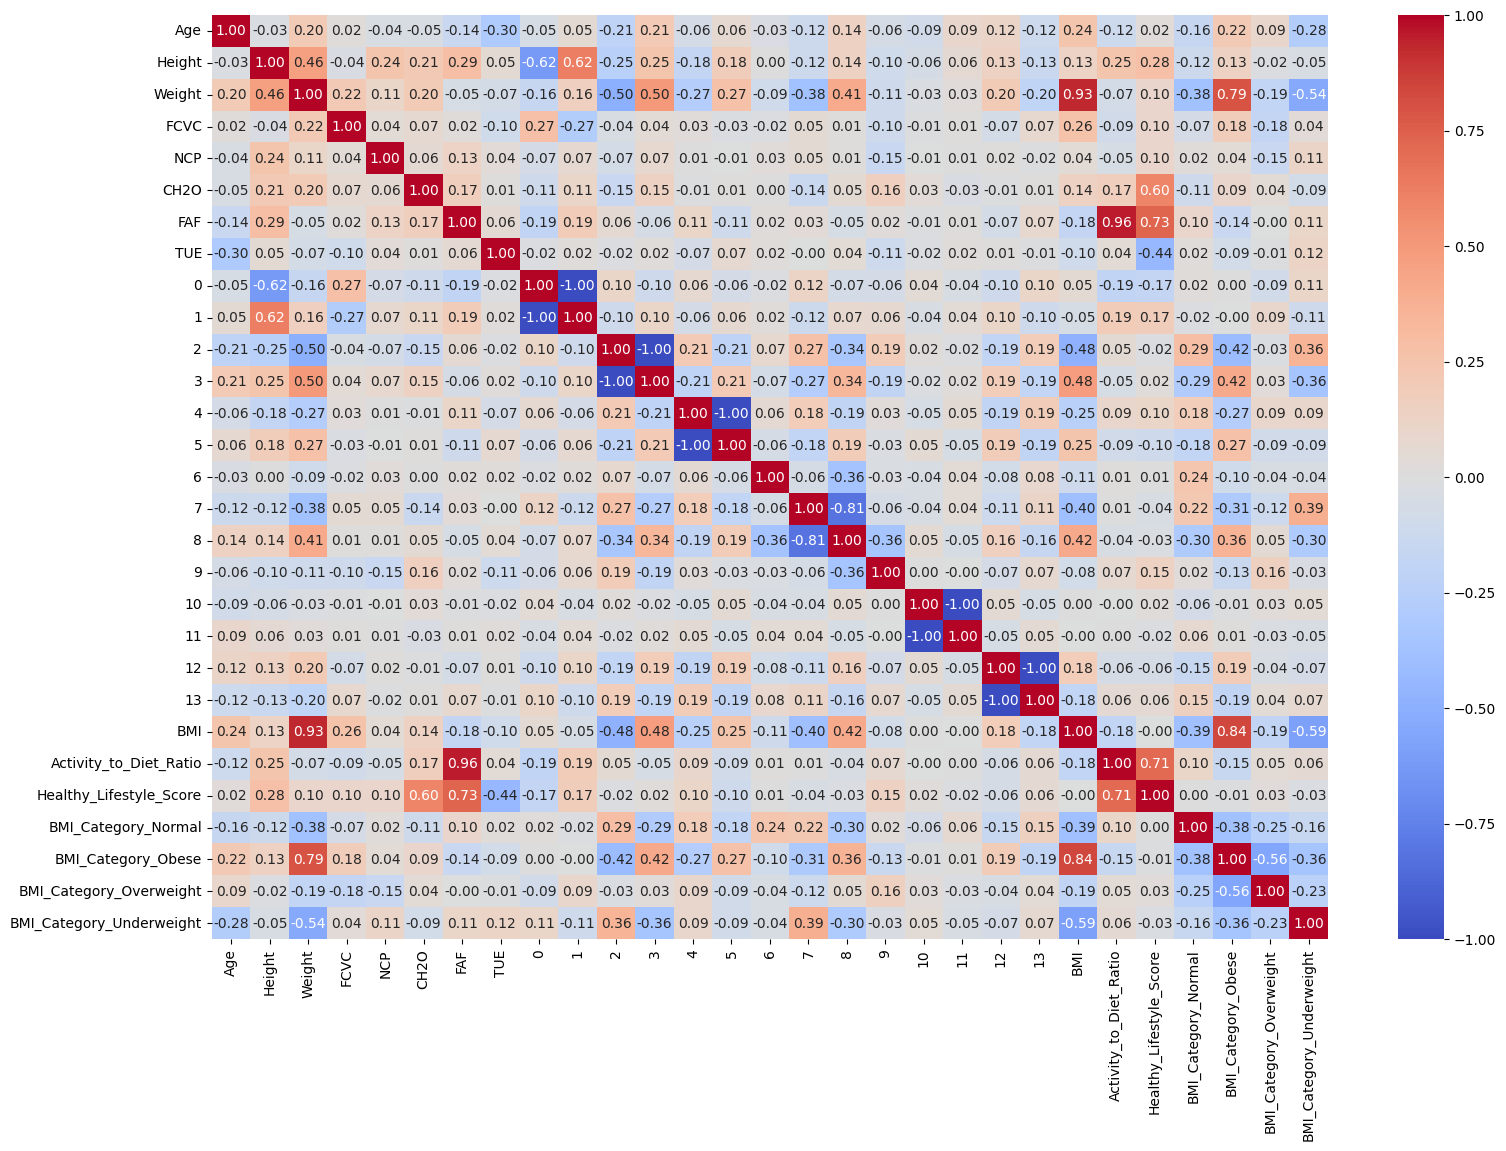

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_X = X.select_dtypes(include=[np.number])

#Compute correlation matrix
corr_matrix = numeric_X.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [15]:
#Dropping weight and faf because they are redundant have a very high correlation with BMI and Activity_to_diet_ratio.
X = X.drop(['Weight', 'FAF'], axis=1)

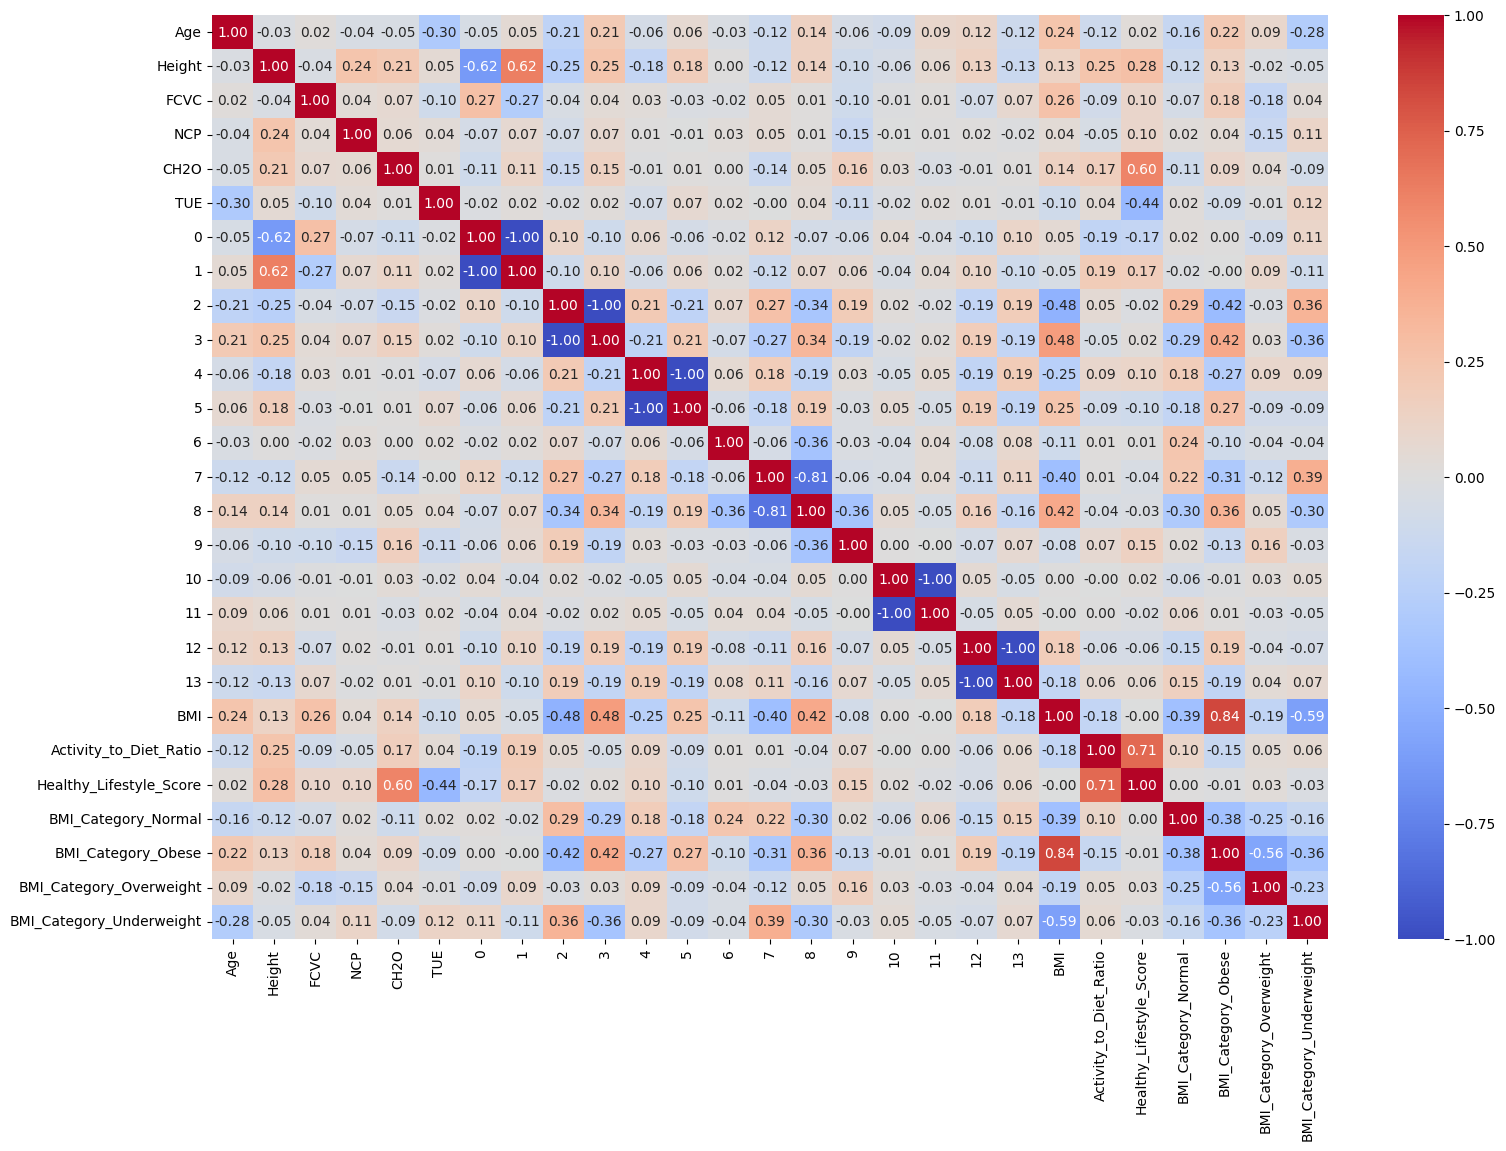

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_X = X.select_dtypes(include=[np.number])

#Compute correlation matrix
corr_matrix = numeric_X.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [17]:
# Import the required function
from sklearn.model_selection import train_test_split

# Ensure all feature names in X are strings
X.columns = X.columns.astype(str)

# Handle any remaining categorical data (if not already encoded)
categorical_cols = X.select_dtypes(include=['object']).columns
if not categorical_cols.empty:
    from sklearn.preprocessing import LabelEncoder
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


In [18]:
# Import required models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Initialize models
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),  # Updated with max_depth
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000)
}


In [19]:
# Import required functions
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Train and evaluate each model with adjustments
results = {}
for model_name, model in models.items():
    try:
        print(f"Training {model_name}...")

        # Add scaling to ensure consistent performance across features
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardize features
            ('model', model)
        ])

        # Perform 5-fold cross-validation with scaling
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

        # Train the model with scaled data
        pipeline.fit(X_train, y_train)

        # Predict on the test set
        y_pred = pipeline.predict(X_test)

        # Compute test accuracy
        test_accuracy = accuracy_score(y_test, y_pred)

        # Store results
        results[model_name] = {
            'Cross-Validation Mean Accuracy': cv_scores.mean(),
            'Test Accuracy': test_accuracy,
            'Classification Report': classification_report(y_test, y_pred, output_dict=True)
        }
    except Exception as e:
        print(f"Error with {model_name}: {e}")
        continue

# Convert results to DataFrame for better readability
if results:  # Check if results are not empty
    results_df = pd.DataFrame(results).T
    print("\nModel Performance Summary:")
    print(results_df[['Cross-Validation Mean Accuracy', 'Test Accuracy']])
else:
    print("No models were successfully trained.")

Training KNN...
Training Decision Tree...
Training Logistic Regression...
Training Naive Bayes...
Training Neural Network...

Model Performance Summary:
                    Cross-Validation Mean Accuracy Test Accuracy
KNN                                       0.899896       0.91253
Decision Tree                             0.964464      0.973995
Logistic Regression                       0.954385      0.969267
Naive Bayes                                0.81458      0.827423
Neural Network                            0.959721      0.964539


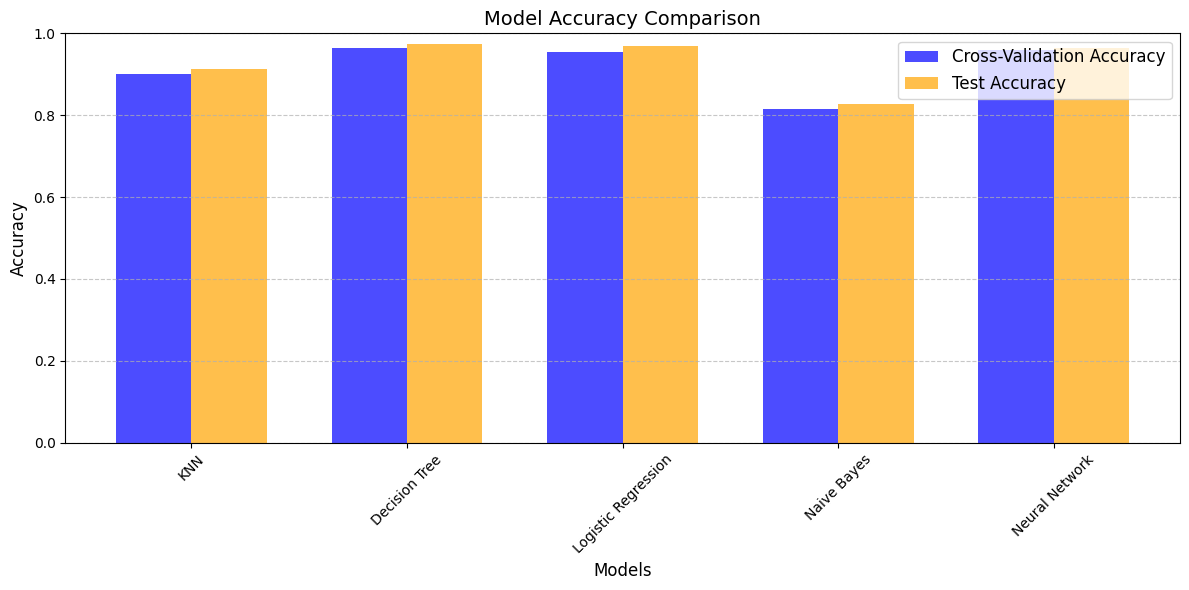

In [20]:
# Bar chart for Cross-Validation and Test Accuracy
if 'Cross-Validation Mean Accuracy' in results_df.columns and 'Test Accuracy' in results_df.columns:
    bar_width = 0.35
    model_names = results_df.index
    cv_accuracies = results_df['Cross-Validation Mean Accuracy']
    test_accuracies = results_df['Test Accuracy']
    r1 = np.arange(len(model_names))
    r2 = [x + bar_width for x in r1]

    plt.figure(figsize=(12, 6))
    plt.bar(r1, cv_accuracies, color='blue', width=bar_width, label='Cross-Validation Accuracy', alpha=0.7)
    plt.bar(r2, test_accuracies, color='orange', width=bar_width, label='Test Accuracy', alpha=0.7)
    plt.title('Model Accuracy Comparison', fontsize=14)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks([r + bar_width / 2 for r in r1], model_names, rotation=45, fontsize=10)
    plt.ylim(0, 1)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Missing expected columns in results_df for visualization.")


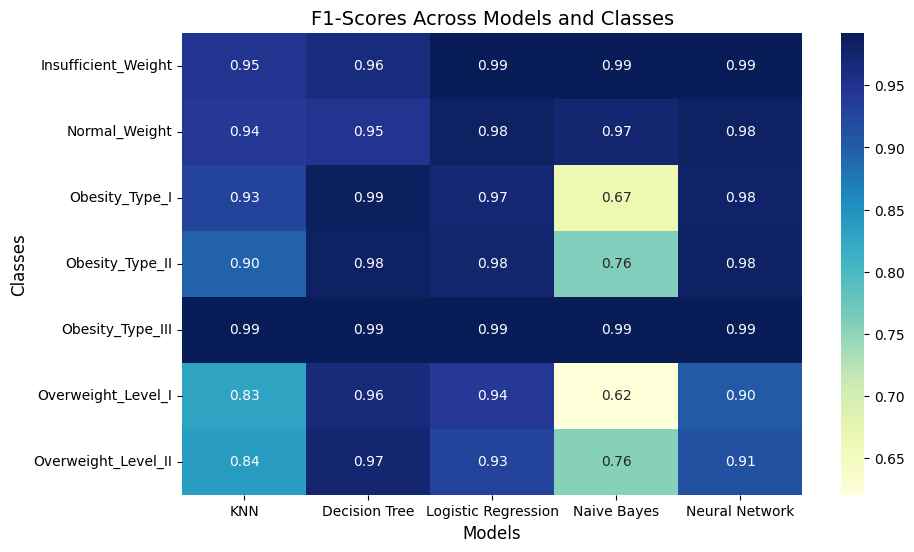

In [21]:
# Extract F1-scores for each class across models
f1_scores = {}
for model, report in zip(results_df.index, results_df['Classification Report']):
    # Ensure class labels match the keys in the classification report
    class_labels = [label for label in report.keys() if label not in ('accuracy', 'macro avg', 'weighted avg')]
    f1_scores[model] = [report[label]['f1-score'] for label in class_labels]

# Create DataFrame for heatmap
f1_df = pd.DataFrame(f1_scores, index=class_labels)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(f1_df, annot=True, cmap='YlGnBu', cbar=True, fmt=".2f")
plt.title('F1-Scores Across Models and Classes', fontsize=14)
plt.ylabel('Classes', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.show()


In [22]:
# Highlight the best-performing model
best_model = results_df['Test Accuracy'].idxmax()
best_model_accuracy = results_df['Test Accuracy'].max()
print(f"\nThe best-performing model is '{best_model}' with a Test Accuracy of {best_model_accuracy:.2f}.")



The best-performing model is 'Decision Tree' with a Test Accuracy of 0.97.


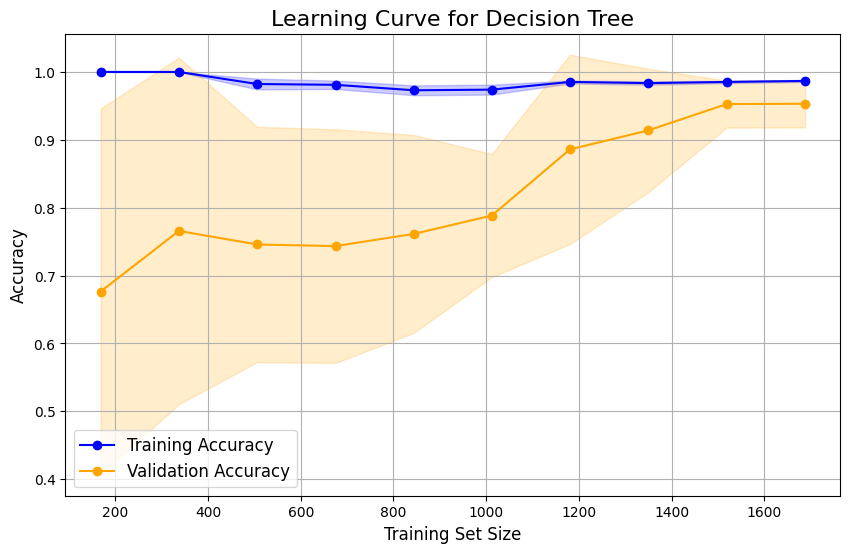

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

def plot_learning_curve(model, X, y, cv=5, scoring='accuracy', model_name="Model"):

    # Define training set sizes
    train_sizes = np.linspace(0.1, 1.0, 10)  # 10 splits from 10% to 100% of data

    # Compute learning curve
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes
    )

    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training Accuracy", color="blue", marker="o")
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="blue",
    )
    plt.plot(train_sizes, validation_scores_mean, label="Validation Accuracy", color="orange", marker="o")
    plt.fill_between(
        train_sizes,
        validation_scores_mean - validation_scores_std,
        validation_scores_mean + validation_scores_std,
        alpha=0.2,
        color="orange",
    )

    plt.title(f"Learning Curve for {model_name}", fontsize=16)
    plt.xlabel("Training Set Size", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(loc="best", fontsize=12)
    plt.grid()
    plt.show()


from sklearn.tree import DecisionTreeClassifier

# Define the model
model = DecisionTreeClassifier(max_depth=5, random_state=42)

# Plot learning curve for the Decision Tree
plot_learning_curve(model, X, Y, cv=5, scoring='accuracy', model_name="Decision Tree")


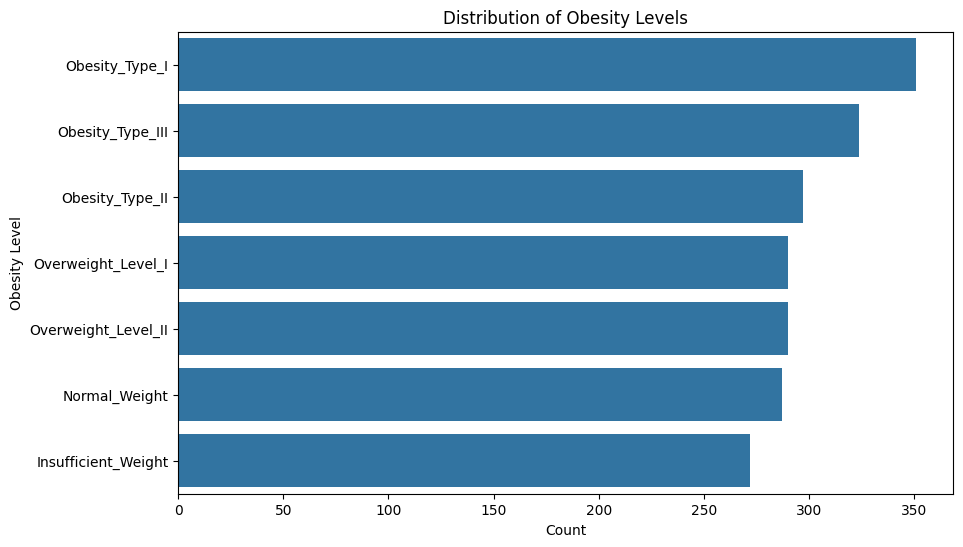

In [24]:
# Distribution of Obesity Levels
plt.figure(figsize=(10, 6))
sns.countplot(y='NObeyesdad', data=dataset, order=dataset['NObeyesdad'].value_counts().index)
plt.title("Distribution of Obesity Levels")
plt.xlabel("Count")
plt.ylabel("Obesity Level")
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.98      1.00      0.99        54
      Normal_Weight       0.98      0.98      0.98        58
     Obesity_Type_I       0.96      1.00      0.98        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.93      0.88      0.90        58
Overweight_Level_II       0.91      0.91      0.91        58

           accuracy                           0.96       423
          macro avg       0.96      0.96      0.96       423
       weighted avg       0.96      0.96      0.96       423



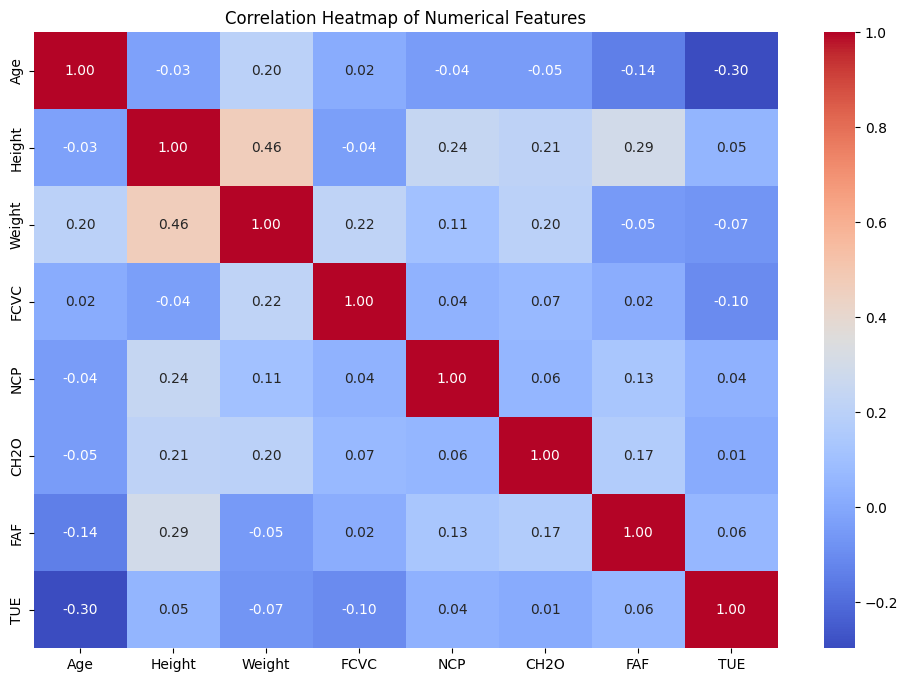

In [26]:
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
plt.figure(figsize=(12, 8))
correlation = dataset[numerical_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

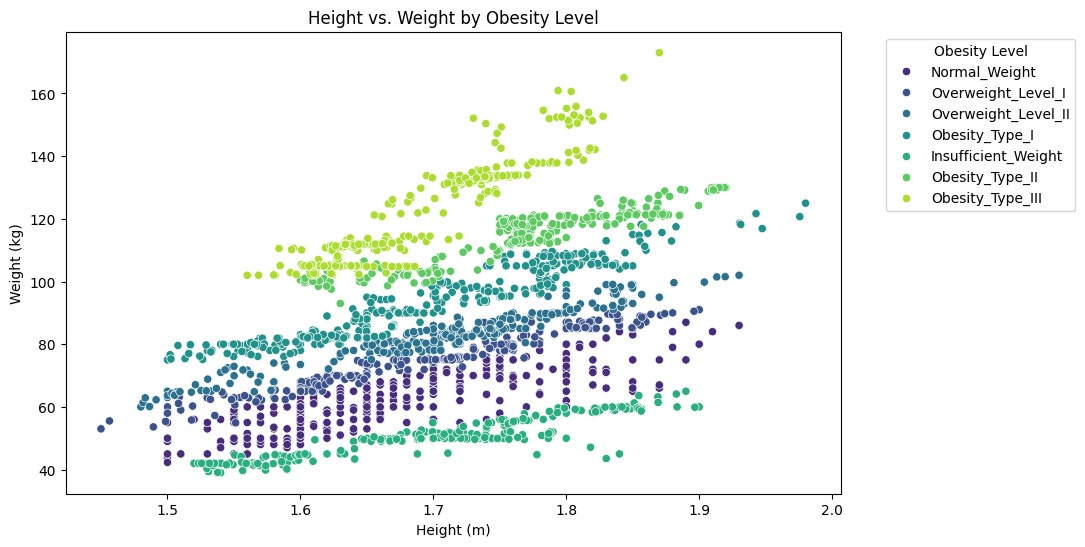

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Height', y='Weight', hue='NObeyesdad', data=dataset, palette='viridis')
plt.title("Height vs. Weight by Obesity Level")
plt.xlabel("Height (m)")
plt.ylabel("Weight (kg)")
plt.legend(title="Obesity Level", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

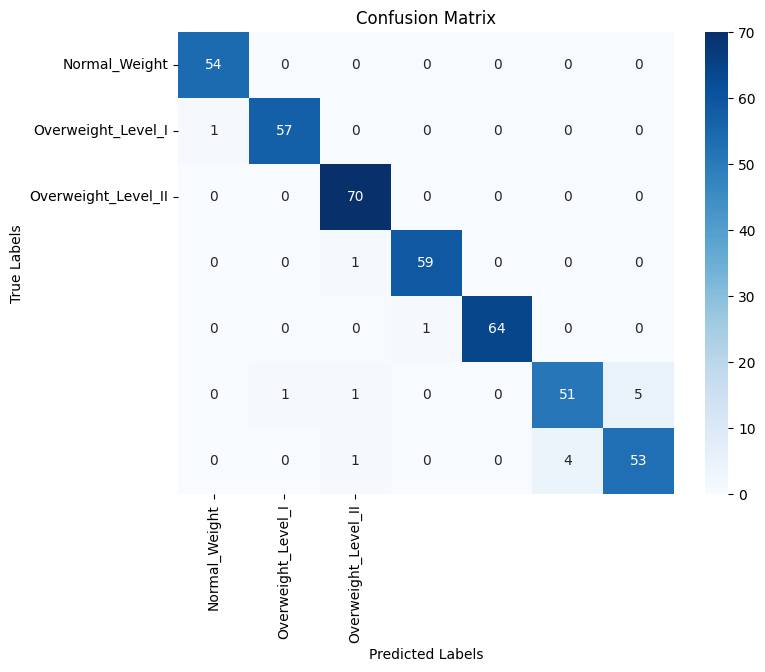

In [28]:
classes = ['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


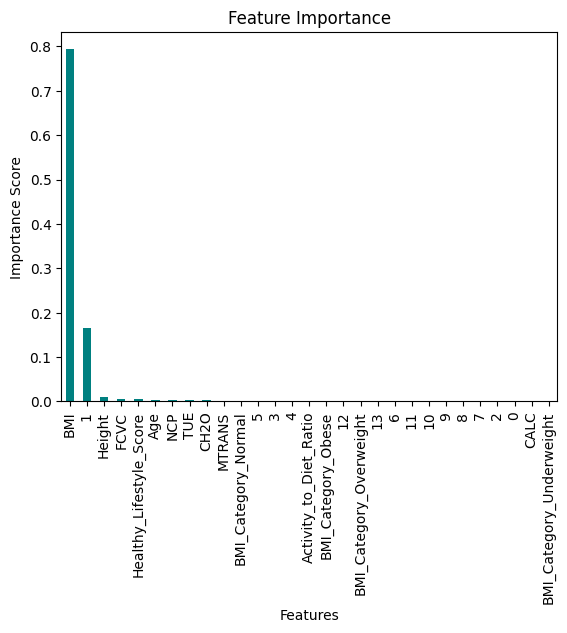

In [29]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

feature_importance = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.plot(kind='bar', color='teal')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()